## Dataset download

In [1]:
DATA_DIR = "/mnt/disk3Tb/slt-datasets/GSL"

In [2]:
from SLTDataset import SLTDataset

In [3]:
train_dataset = SLTDataset(data_dir=DATA_DIR, split='train', input_mode='pose', output_mode='text')
val_dataset = SLTDataset(data_dir=DATA_DIR, split='val', input_mode='pose', output_mode='text')
test_dataset = SLTDataset(data_dir=DATA_DIR, split='test', input_mode='pose', output_mode='text')

print(len(train_dataset), len(val_dataset), len(test_dataset))

Loaded metadata: {
    "name": "The Greek Sign Language (GSL) Dataset",
    "id": "greek_sl_dataset",
    "url": "https://vcl.iti.gr/dataset/gsl/",
    "download_link": "https://drive.google.com/drive/folders/18ruYi9MULMm1KQtUgdIhN0m-XilRhncg",
    "mirror_link": "https://drive.google.com/drive/folders/1EAVE5dxQIKGAL2yB0alvgTlv2t3JKW5v?usp=sharing",
    "input_language": "Greek Sign Language (GSL)",
    "output_language": "greek",
    "input_types": [
        "video",
        "pose"
    ],
    "output_types": [
        "text",
        "gloss"
    ]
}
Loaded annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files:   0%|          | 0/8821 [00:00<?, ?it/s]

Validating files: 100%|██████████| 8821/8821 [00:00<00:00, 238605.66it/s]


Dataset loaded correctly
Loaded metadata: {
    "name": "The Greek Sign Language (GSL) Dataset",
    "id": "greek_sl_dataset",
    "url": "https://vcl.iti.gr/dataset/gsl/",
    "download_link": "https://drive.google.com/drive/folders/18ruYi9MULMm1KQtUgdIhN0m-XilRhncg",
    "mirror_link": "https://drive.google.com/drive/folders/1EAVE5dxQIKGAL2yB0alvgTlv2t3JKW5v?usp=sharing",
    "input_language": "Greek Sign Language (GSL)",
    "output_language": "greek",
    "input_types": [
        "video",
        "pose"
    ],
    "output_types": [
        "text",
        "gloss"
    ]
}
Loaded annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 588/588 [00:00<00:00, 225702.46it/s]


Dataset loaded correctly
Loaded metadata: {
    "name": "The Greek Sign Language (GSL) Dataset",
    "id": "greek_sl_dataset",
    "url": "https://vcl.iti.gr/dataset/gsl/",
    "download_link": "https://drive.google.com/drive/folders/18ruYi9MULMm1KQtUgdIhN0m-XilRhncg",
    "mirror_link": "https://drive.google.com/drive/folders/1EAVE5dxQIKGAL2yB0alvgTlv2t3JKW5v?usp=sharing",
    "input_language": "Greek Sign Language (GSL)",
    "output_language": "greek",
    "input_types": [
        "video",
        "pose"
    ],
    "output_types": [
        "text",
        "gloss"
    ]
}
Loaded annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 881/881 [00:00<00:00, 221946.17it/s]

Dataset loaded correctly
8821 588 881


## Dataset analysis

In [4]:
src_lenghts = []
texts = []

for x, y in train_dataset:
	src_lenghts.append(x.shape[0])
	texts.append(y)

### Frames analysis for padding and truncation

In [5]:
import pandas as pd


src_lengths_df = pd.Series(src_lenghts)
src_lengths_df.describe(percentiles=[.75, .9, .95, .99])

count    8821.000000
mean       99.978687
std        78.051631
min         6.000000
50%        88.000000
75%       135.000000
90%       192.000000
95%       252.000000
99%       349.800000
max       615.000000
dtype: float64

<Axes: >

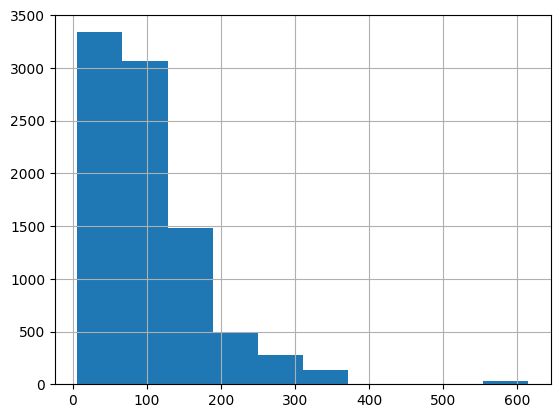

In [6]:
src_lengths_df.hist()

### Text tokenization and analysis for padding and truncation

In [9]:
from transformers import AutoTokenizer
from WordLevelTokenizer import WordLevelTokenizer


USE_BERT_EMBEDDINGS = False

if USE_BERT_EMBEDDINGS:
    TEXT_MODEL = "nlpaueb/bert-base-greek-uncased-v1"
    tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
else:
    TEXT_MODEL = None
    tokenizer = WordLevelTokenizer(texts)

In [10]:
BOS_IDX = tokenizer.cls_token_id if tokenizer.cls_token_id is not None else -1
EOS_IDX = tokenizer.sep_token_id if tokenizer.sep_token_id is not None else -1
PAD_IDX = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else -1

print(f"BOS_IDX: {BOS_IDX}, EOS_IDX: {EOS_IDX}, PAD_IDX: {PAD_IDX}")

BOS_IDX: 2, EOS_IDX: 3, PAD_IDX: 0


In [15]:
tokenized_sequences = tokenizer(texts, padding="max_length", max_length=25)

In [16]:
tokens_length = [len([t for t in tokens if t != 0]) for tokens in tokenized_sequences['input_ids']]
print(max(tokens_length))

20


In [17]:
print(texts[0])
print(tokenized_sequences['input_ids'][0])

γεια σας πώς μπορώ να βοηθήσω
[2, 4, 5, 6, 7, 8, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch


USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS:
	flattened_tgts = [item for sublist in tokenized_sequences["input_ids"] for item in sublist if item != PAD_IDX]
	token_ids = sorted(list(set(flattened_tgts)))
	class_weights = compute_class_weight("balanced", classes=np.array(token_ids), y=flattened_tgts)
	class_weights_complete = torch.ones(tokenizer.vocab_size)
	class_weights_complete[token_ids] = torch.from_numpy(class_weights).float()

In [19]:
if USE_CLASS_WEIGHTS:
	print(tokenizer.convert_ids_to_tokens([i for i in range(10)]))
	print(class_weights_complete[:10].tolist())

## Preprocessing and dataloader generation

In [20]:
import torch
from torch import Tensor
import torch.utils.data as utils


MAX_FRAMES = 252
MAX_TOKENS = 25
BATCH_SIZE = 128

LANDMARKS_USED = ["pose", "lhand", "rhand"]
USE_3D = False
NORM_BY_HW = False
HW = (1, 1)

holistic_landmarks = ["pose" for i in range(33)] + ["face" for i in range(468)] + ["lhand" for i in range(21)] + ["rhand" for i in range(21)]
LANDMARKS_MASK = torch.tensor([True if kp in LANDMARKS_USED else False for kp in holistic_landmarks])


def filter_landmarks(datum: Tensor, mask: Tensor, use_3d: bool):
	'''
		Filter landmarks by mask.
		Args:
			datum: Tensor of shape (S, L, D)
			landmarks: list of landmarks to keep
		Returns:
			Tensor of shape (S, L', D)
	'''
	# delete dummy dimension and transpose to (L, S, D) for filtering
	datum = datum.squeeze(1).permute(1, 0, 2)
	datum = datum[mask]
	if not use_3d:
		datum = datum[:, :, :2]
	return datum.permute(1, 0, 2)

def norm_landmarks(datum: Tensor, hw: tuple):
	'''
		Normalize landmarks by HW.
		Args:
			datum: Tensor of shape (S, L, D)
			hw: (H, W)
		Returns:
			Tensor of shape (S, L, D)
	'''
	return datum / torch.tensor(hw).float()

def flatten_landmarks(datum: Tensor):
	'''
		Reshape the pose of datum only keeping the first dimension S (sequence lenght) and flattening the number of landmarks L and their dimensions D.
		Args:
			datum: Tensor of shape (S, D, L)
		Returns:
			Tensor of shape (frames, D * L)
	'''
	return datum.reshape(datum.shape[0], -1)

def pad_truncate_src(datum: Tensor, max_len: int):
	'''Pad the pose to max_len or truncate it'''
	if datum.size(0) < max_len:
		return torch.cat([datum, torch.zeros(max_len - datum.size(0), datum.size(1))])
	else:
		return datum[:max_len]


def collate_fn(batch):
	src = [
		pad_truncate_src(
			flatten_landmarks(
				norm_landmarks(
					filter_landmarks(
						torch.nan_to_num(x)
					, LANDMARKS_MASK, USE_3D), HW
				)
			), MAX_FRAMES)
	for x, y in batch]
	src = torch.stack(src)
	tgt = [y for x, y in batch]
	tgt = tokenizer(tgt, padding='max_length', max_length=MAX_TOKENS, return_tensors='pt')["input_ids"]
	return src, tgt

train_loader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
validation_loader = utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [21]:
for src, tgt in train_loader:
  print(src.shape)
  print(tgt.shape)
  break

torch.Size([128, 252, 150])
torch.Size([128, 25])


## Model

### Model definition

In [25]:
from KeypointsTransformer import KeypointsTransformer
from helpers import generate_square_subsequent_mask, create_target_mask


D_MODEL = 16
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 4
DROPOUT = 0.2

num_keypoints = LANDMARKS_MASK.sum().item()
IN_FEATURES = int(num_keypoints*(3 if USE_3D else 2))

model = KeypointsTransformer(
    src_max_len=MAX_FRAMES,
    tgt_max_len=MAX_TOKENS,
    in_features=IN_FEATURES,
    tgt_vocab_size=tokenizer.vocab_size,
    d_model=D_MODEL,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout=DROPOUT,
    use_bert_embeddings=USE_BERT_EMBEDDINGS,
)

pytorch_model.bin:  67%|██████▋   | 304M/454M [00:16<00:06, 23.4MB/s] Error while downloading from https://cdn-lfs.huggingface.co/nlpaueb/bert-base-greek-uncased-v1/8af7668e2911fd413a9de43b2449ce2e5374a458d5609ba0fecbd923470ad181?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1714733804&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDczMzgwNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9ubHBhdWViL2JlcnQtYmFzZS1ncmVlay11bmNhc2VkLXYxLzhhZjc2NjhlMjkxMWZkNDEzYTlkZTQzYjI0NDljZTJlNTM3NGE0NThkNTYwOWJhMGZlY2JkOTIzNDcwYWQxODE%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=L4XPeDLGZUraEFTTloX9BwYuzQz98xjAdXnYNwOBOwaInPRTPH0VBD4J5srB28ltEUYDEuSf3MA66S0PFEEENvjXPZfpPzCX3e7rpOUsgfXOp3CTiYO1IMnJv2Lc6dcDDfPcUqarTIHAjihysbuxV4DR%7EI%7ExVaJawoIwOG%7Ed9EWUulEZ7sBOpmn

## Model training

In [28]:
import lightning.pytorch.utilities.model_summary.model_summary as model_summary

from Translator import Translator
from LightningKeypointsTransformer import LKeypointsTransformer


LR = 1e-3
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

BATCH_SIZE_TEST = 1
example_input_array = (
    torch.randn(BATCH_SIZE_TEST, MAX_FRAMES, IN_FEATURES),
    torch.randint(0, tokenizer.vocab_size, (BATCH_SIZE_TEST, MAX_TOKENS)),
    torch.zeros(MAX_TOKENS, MAX_TOKENS),
    torch.randint(0, 2, (BATCH_SIZE_TEST, MAX_TOKENS)).bool()
)
translator = Translator(model, tokenizer, MAX_TOKENS, DEVICE)
l_model = LKeypointsTransformer(model, DEVICE, tokenizer, translator, LR, example_input_array, class_weights)
model_summary.summarize(l_model, max_depth=10)

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


    | Name                                                                | Type                            | Params | In sizes                                                                                                                       | Out sizes         
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0   | model                                                               | KeypointsTransformer            | 114 M  | [[1, 252, 150], [1, 25], [25, 25], [1, 25]]                                                                                    | [1, 25, 35000]    
1   | model.batch_norm                                                    | BatchNorm1d                     | 300    | [1, 150, 252]                                                             

In [29]:
import lightning.pytorch as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger


PRECISION = 32

wandb_logger = WandbLogger(project="gsl", log_model="all")
wandb_logger.experiment.config.update({
	# System hyperparameters
	"DEVICE": DEVICE,
	"PRECISION": PRECISION,
	# Data hyperparameters
	"BATCH_SIZE": BATCH_SIZE,
	"MAX_FRAMES": MAX_FRAMES,
	"MAX_TOKENS": MAX_TOKENS,
	"TEXT_MODEL": TEXT_MODEL,
	"LANDMARKS_USED": str(LANDMARKS_USED),
	"USE_3D": USE_3D,
	"NORM_BY_HW": NORM_BY_HW,
	# Model hyperparameters
	"D_MODEL": D_MODEL,
	"DROPOUT": DROPOUT,
	"USE_BERT_EMBEDDINGS": USE_BERT_EMBEDDINGS,
	"NUM_ENCODER_LAYERS": NUM_ENCODER_LAYERS,
	# Training hyperparameters
	"USE_CLASS_WEIGHTS": USE_CLASS_WEIGHTS,
	"LR": LR,
})

checkpoint_callback = ModelCheckpoint(
	monitor='val_loss',
	dirpath='checkpoints/',
	filename=f'rwth-{wandb_logger.experiment.name}-best-{{epoch:02d}}-{{step:02d}}-{{val_loss:.2f}}',
	mode='min',
	save_last=True
)
checkpoint_callback.CHECKPOINT_NAME_LAST = f"rwth-{wandb_logger.experiment.name}-last"

trainer = L.Trainer(
    logger=wandb_logger,
    default_root_dir="./checkpoint",
		precision=PRECISION,
    callbacks=[
		EarlyStopping(monitor="val_loss", mode="min", patience=20),
		checkpoint_callback,],
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedroodb (lidiaa). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(
    model=l_model,
    train_dataloaders=train_loader,
    val_dataloaders=validation_loader,
)

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/pdalbianco/Github/slt_models_tryout/gsl/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(

  | Name     | Type                 | Params | In sizes                                    | Out sizes     
-----------------------------------------------------------------------------------------------------------------
0 | model    | KeypointsTransformer | 114 M  | [

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 1:  35%|███▍      | 24/69 [00:20<00:38,  1.16it/s, v_num=x8v5]

Epoch 16: 100%|██████████| 69/69 [00:20<00:00,  3.43it/s, v_num=x8v5]

wandb: WARNING Cache size exceeded. Attempting to reclaim space...


Epoch 28: 100%|██████████| 69/69 [00:19<00:00,  3.52it/s, v_num=x8v5]

wandb: WARNING Cache size exceeded. Attempting to reclaim space...


Epoch 39: 100%|██████████| 69/69 [00:20<00:00,  3.43it/s, v_num=x8v5]

OSError: [Errno 28] No space left on device

--- Logging error ---


Traceback (most recent call last):
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/logging/__init__.py", line 1114, in emit
    self.flush()
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/logging/__init__.py", line 1094, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/threading.py", line 1002, in _bootstrap
    self._bootstrap_inner()
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/

In [ ]:
import os
import glob


CHKP = glob.glob(f"checkpoints/rwth-{wandb_logger.experiment.name}-best*")[0]
l_model = LKeypointsTransformer.load_from_checkpoint(CHKP, model=model, num_classes=tokenizer.vocab_size)

trainer.test(
    model=l_model,
	  dataloaders=test_loader,
    ckpt_path=CHKP,
)

Restoring states from the checkpoint path at checkpoints/rwth-glowing-glade-3-best-epoch=129-step=17940-val_loss=1.33.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at checkpoints/rwth-glowing-glade-3-best-epoch=129-step=17940-val_loss=1.33.ckpt
/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 14/14 [00:48<00:00,  0.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        bleu_1_beam        │    0.0667879581451416     │
│       bleu_1_greedy       │    0.07633455097675323    │
│        bleu_2_beam        │   0.001135073835030198    │
│       bleu_2_greedy       │   0.002686360152438283    │
│        bleu_3_beam        │   0.001135073835030198    │
│       bleu_3_greedy       │   0.0025793195236474276   │
│        bleu_4_beam        │   0.001135073835030198    │
│       bleu_4_greedy       │   0.002270147670060396    │
│       test_accuracy       │     0.699288010597229     │
│         test_loss         │     1.257958173751831     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.257958173751831,
  'test_accuracy': 0.699288010597229,
  'bleu_1_greedy': 0.07633455097675323,
  'bleu_2_greedy': 0.002686360152438283,
  'bleu_3_greedy': 0.0025793195236474276,
  'bleu_4_greedy': 0.002270147670060396,
  'bleu_1_beam': 0.0667879581451416,
  'bleu_2_beam': 0.001135073835030198,
  'bleu_3_beam': 0.001135073835030198,
  'bleu_4_beam': 0.001135073835030198}]

In [ ]:
translation_results_df = pd.read_csv(f"translation-results-{wandb_logger.experiment.name}.csv")
translation_results_df.head()

,y,trans_greedy,trans_beam,bleu_1_greedy,bleu_2_greedy,bleu_3_greedy,bleu_4_greedy,bleu_1_beam,bleu_2_beam,bleu_3_beam,bleu_4_beam
0,γεια σας πώς μπορώ να βοηθήσω,θα φέρετε και φωτοτυπία ταυτότητας,θα φέρετε και φωτοτυπία ταυτότητας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,θέλω να κάνω καταγγελία,θα φέρετε και φωτοτυπία ταυτότητας,θα φέρετε και φωτοτυπία ταυτότητας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ποιο είναι το πρόβλημα,θα φέρετε και φωτοτυπία ταυτότητας,θα ενημερωθείτε από τα ελτα για ραντεβού,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,διατάραξη κοινής ησυχίας,θα ελέγξουμε την αίτηση και τα δικαιολογητικά ...,θα αποφύγετε γαλακτοκομικά χορταρικά και όσπρια,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ποιος σας ενοχλεί,θα φέρετε και φωτοτυπία ταυτότητας,θα φέρετε και φωτοτυπία ταυτότητας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
